<a href="https://colab.research.google.com/github/richtea88/CM3710/blob/main/Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Richard Thomson - 0603831 - CM3710 - Machine Learning & AI
## Convolutional Neural Network (script 2 of 2)

In [2]:
# Import Libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import PIL

from statistics import harmonic_mean

from os import path
import os
import numpy as np

In [3]:
# Setting Constants
# DATA_DIR should be set to the location of the provided Training and Validation data set
# EVAL_DIR should be set to te location of the provided Evaluation data set
DATA_DIR = '/content/drive/MyDrive/Train_Test_Coursework/'
EVAL_DIR = '/content/drive/MyDrive/Evaluation Data Set/'
batch_size = 12
img_height = 1000 # 1900
img_width = 1200 # 2300
channels = 3

# Displays plots inline in notework instead of in a new window
%matplotlib inline

In [4]:
# Load training / validation 
if channels == 3:
  c_mode = "rgb"
elif channels == 4:
  c_mode = "rgba"
elif channels == 1:
  c_mode = "grayscale"
else:
  channels = 1
  c_mode = "grayscale"

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode=c_mode,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode=c_mode,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Class names from folder structure
class_names = train_ds.class_names
print(class_names)

# number of classes
num_classes = len(class_names)


Found 200 files belonging to 4 classes.
Using 160 files for training.
Found 200 files belonging to 4 classes.
Using 40 files for validation.
['Detail Drawing', 'Isometric', 'Photo', 'Piping and Instrumentation Diagram']


In [5]:
# performance optimisation 
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE
# caching images with prefetch - buffer size determines by Autotune
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


I tested a number of different pre-processing techniques. I found that horizontal and vertical improved the models performance, but random rotation seemed to reduce it. I opted to resize my image rather than centre crop as this also seemed to increase performance.

In [6]:
# Defining pre-process layers
# data_augmentation layer
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, channels)),
  #layers.RandomRotation(0.2), - seemed to reduce model accuracy
])

# resize_and_rescale
resize_and_rescale = tf.keras.Sequential([
#layers.Resizing(img_height, img_width),
# Opted to crop centre of image rather than resize the image
# normalisation of rgb 0-255 to values between 0-1
layers.Rescaling(1./255)
])

# crop centre of image
crop_centre = tf.keras.Sequential([
    layers.CenterCrop(height=800, width=800)
])

I tested a several different architectures, due to colab limitations I reduced the number of layers, filter sizes and kernel sizes to allow the model to train.

In [7]:
# Model Architecture

model = Sequential([
  data_augmentation,
  crop_centre,
  resize_and_rescale,
  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])


In [8]:
# compile model with adam optimizer
# Spare Categorical Cross Entropy for loss - for multiclass label classification
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [9]:
# Summary of the model with number of trainable and non-trainable parameters
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1000, 1200, 3)     0         
                                                                 
 sequential_2 (Sequential)   (None, 800, 800, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 800, 800, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 800, 800, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 400, 400, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 400, 400, 32)      9248      
                                                      

In [10]:
# Function courtesy of https://gist.github.com/jamesmishra/34bac09176bc07b1f0c33886e4b19dc7
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [11]:
bytess = keras_model_memory_usage_in_bytes(model, batch_size=batch_size)
gb = bytess / (1024*1024*1024)
print(f'This model requires approximately {gb} Gigabytes to train')

This model requires approximately 2.448598299175501 Gigabytes to train


In [12]:
# set number of training epochs
epochs=10
# train model - Kyle, again, sorry if this takes forever to run in Colab. Locally this model takes approx 10 seconds per epoch - Feel free to reduce epochs to save time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
14/14 [==============================] - 192s 13s/step - loss: 19.1819 - accuracy: 0.2500 - val_loss: 1.7213 - val_accuracy: 0.3750
Epoch 2/10
14/14 [==============================] - 152s 11s/step - loss: 1.1582 - accuracy: 0.4563 - val_loss: 1.0414 - val_accuracy: 0.4250
Epoch 3/10
14/14 [==============================] - 159s 11s/step - loss: 1.0093 - accuracy: 0.5125 - val_loss: 1.0136 - val_accuracy: 0.4250
Epoch 4/10
14/14 [==============================] - 155s 11s/step - loss: 0.9152 - accuracy: 0.5250 - val_loss: 0.9220 - val_accuracy: 0.5000
Epoch 5/10
14/14 [==============================] - 154s 11s/step - loss: 1.1283 - accuracy: 0.5063 - val_loss: 1.1955 - val_accuracy: 0.5500
Epoch 6/10
14/14 [==============================] - 159s 11s/step - loss: 0.9490 - accuracy: 0.5562 - val_loss: 0.9972 - val_accuracy: 0.4250
Epoch 7/10
14/14 [==============================] - 155s 11s/step - loss: 0.7282 - accuracy: 0.6625 - val_loss: 0.6982 - val_accuracy: 0.7250
Epoch

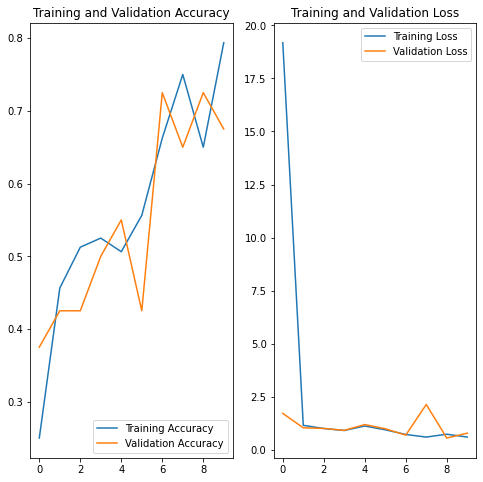

In [13]:
# get training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
# get training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Plot of The model training/validation accuracy and training/validation loss.



In [14]:
# custom function for predicting single files. 

def predict_file(file):
    if not file.endswith('png'):
      return {'File': file, 'Class': 'Inavlid input file', 'Confidence': 'Inavlid input file'}

    # load image
    iso1 = tf.keras.utils.load_img(file, target_size=(img_height, img_width), color_mode=c_mode)
    # convert to array
    img_array = tf.keras.utils.img_to_array(iso1)
    # expand array dimensions to create a batch of 1 for model input
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    # predict
    predictions = model.predict(img_array)
    # get list of class probabilities
    score = tf.nn.softmax(predictions[0])
    # np.argmax returns the index of the largest probability in the list, use to retireve class name
    predicted = class_names[np.argmax(score)]
    # confidence is max probability as a percentage
    confidence = 100 * np.max(score)

    print(
        "{} most likely belongs to {} with a {:.2f} percent confidence."
            .format(file, predicted, confidence)
    )
    # return with 
    return {'File': file, 'Class': predicted, 'Confidence': confidence}


In [15]:
# custom function for evaluating model
# 
def evaluate_model():
    test_files = []
    for file in os.listdir(EVAL_DIR):
        file = EVAL_DIR + file
        if 'Isometric' in file:
            test_files.append({'File': file, 'Class': 'Isometric'})
        if 'pid' in file:
            test_files.append({'File': file, 'Class': 'Piping and Instrumentation Diagram'})
        if 'photo' in file:
            test_files.append({'File': file, 'Class': 'Photo'})
        if 'Detail' in file:
            test_files.append({'File': file, 'Class': 'Detail Drawing'})

    confusion_matrix = {'Isometric': {'Isometric': 0, 'Piping and Instrumentation Diagram': 0, 'Photo': 0, 'Detail Drawing': 0},
                        'Piping and Instrumentation Diagram': {'Isometric': 0, 'Piping and Instrumentation Diagram': 0, 'Photo': 0, 'Detail Drawing': 0},
                        'Photo': {'Isometric': 0, 'Piping and Instrumentation Diagram': 0, 'Photo': 0, 'Detail Drawing': 0},
                        'Detail Drawing': {'Isometric': 0, 'Piping and Instrumentation Diagram': 0, 'Photo': 0, 'Detail Drawing': 0}}

    for dic in test_files:
        #print(dic['File'])
        prediction = predict_file(dic['File'])
        prediction = prediction['Class']
        classification = dic['Class']
        if prediction == classification:
            confusion_matrix[classification][classification] += 1
        else:
            confusion_matrix[classification][prediction] += 1

    confusion_matrix_df = pd.DataFrame(confusion_matrix)
    classes = ['Isometric', 'Piping and Instrumentation Diagram', 'Photo', 'Detail Drawing']
    class_stats = []
    for c in classes:
        other_classes = [cls for cls in classes if cls != c]
        TP = confusion_matrix_df[c][c]
        TN = 0
        for o_c in other_classes:
            for oo_c in other_classes:
                TN += confusion_matrix_df[o_c][oo_c]
        FP_row = confusion_matrix_df.loc[c]
        FP = 0
        for i, item in FP_row.iteritems():
            if i != c:
                FP += item
        FN_col = confusion_matrix_df[c]
        FN = 0
        for j, row in FN_col.iteritems():
            if j != c:
                FN += row
        precision = TP / (FP + TP)
        recall = TP / (TP + FN)
        F1 = harmonic_mean([precision, recall])
        class_stats.append(
            {'Class': c, 'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN, 'Precision': precision, 'Recall': recall, 'F1': F1})
    print()
    class_stats_df = pd.DataFrame(class_stats)
    Total_TP = class_stats_df['TP'].sum()
    Total_FP = class_stats_df['FP'].sum()
    Total_TN = class_stats_df['TN'].sum()
    Total_FN = class_stats_df['FN'].sum()
    Total_precision = Total_TP / (Total_TP + Total_FN)
    Total_Recall = Total_TP / (Total_TP + Total_FN)  # Killer movie, man
    Micro_F1 = harmonic_mean([Total_precision, Total_Recall])
    Macro_F1 = class_stats_df['F1'].sum() / 4
    model_stats = [{'TP': Total_TP, 'TN': Total_TN, 'FP': Total_FP, 'FN': Total_FN, 'Precision': Total_precision,
                   'Recall': Total_Recall, 'Micro F1': Micro_F1, 'Macro F1': Macro_F1}]
    model_stats_df = pd.DataFrame(model_stats)
    return confusion_matrix_df, class_stats_df, model_stats_df

In [16]:
confusion_matrix, class_stats, model_stats = evaluate_model()
#confusion_matrix()

/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (4).png most likely belongs to Piping and Instrumentation Diagram with a 65.57 percent confidence.
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (7).png most likely belongs to Detail Drawing with a 46.24 percent confidence.
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (1).png most likely belongs to Detail Drawing with a 72.64 percent confidence.
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (8).png most likely belongs to Piping and Instrumentation Diagram with a 52.46 percent confidence.
/content/drive/MyDrive/Evaluation Data Set/Detail Drawing (9).png most likely belongs to Piping and Instrumentation Diagram with a 49.92 percent confidence.
/content/drive/MyDrive/Evaluation Data Set/Isometric (1).png most likely belongs to Piping and Instrumentation Diagram with a 55.42 percent confidence.
/content/drive/MyDrive/Evaluation Data Set/Isometric (4).png most likely belongs to Detail Drawing with

In [17]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

#Display Confusion Matrix
data_table.DataTable(confusion_matrix)

,Isometric,Piping and Instrumentation Diagram,Photo,Detail Drawing
Isometric,1,0,0,0
Piping and Instrumentation Diagram,4,10,0,5
Photo,0,0,10,0
Detail Drawing,5,0,0,5


In [18]:
#Display Class Stats
data_table.DataTable(class_stats)

,Class,TP,TN,FP,FN,Precision,Recall,F1
0,Isometric,1,30,0,9,1.000000,0.1,0.181818
1,Piping and Instrumentation Diagram,10,21,9,0,0.526316,1.0,0.689655
2,Photo,10,30,0,0,1.000000,1.0,1.000000
3,Detail Drawing,5,25,5,5,0.500000,0.5,0.500000


In [19]:
#Display Model Stats
data_table.DataTable(model_stats)

,TP,TN,FP,FN,Precision,Recall,Micro F1,Macro F1
0,26,106,14,14,0.65,0.65,0.65,0.592868
